In [10]:
import nltk
import numpy as np
import pandas as pd
import re
import string
import json
import matplotlib.pyplot as plt
from nltk.corpus import reuters, stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
# Download NLTK resources
nltk.download('reuters')
nltk.download('stopwords')

# Step 1: Tokenization and Preprocessing
class Tokenizer:
    def __init__(self, stop_words=None):
        self.stop_words = stop_words or set(stopwords.words('english'))
    
    def tokenize(self, text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
        text = re.sub(r"\d+", " ", text)
        tokens = text.split()
        return [word for word in tokens if word not in self.stop_words]

# Custom stopwords
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update({"mln", "lt", "pct", "dlrs", "vs", "000", "said", "year", "loss", "profit", "net"})

# Load Reuters dataset
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]
labels = [reuters.categories(doc_id) for doc_id in documents]

tokenizer = Tokenizer(stop_words=custom_stopwords)
tokenized_texts = [tokenizer.tokenize(text) for text in texts]

# Step 2: Convert texts to Bag-of-Words representation
vectorizer = CountVectorizer(max_features=5000, stop_words=list(custom_stopwords))
X_bow = vectorizer.fit_transform([" ".join(tokens) for tokens in tokenized_texts])

# Step 3: LDA Topic Modeling
n_topics = 15
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_lda = lda.fit_transform(X_bow)

# Display top words in each topic
print("LDA Topics:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))

# Step 4: Load GloVe Embeddings
def load_glove_embeddings(glove_path, embedding_dim, vocabulary):
    embeddings_index = {}
    with open(glove_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
    for word, idx in vocabulary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

glove_path = "glove.6B.100d.txt"  # Update path accordingly
embedding_dim = 100
vocabulary = {word: idx for idx, word in enumerate(vectorizer.get_feature_names_out())}
embedding_matrix = load_glove_embeddings(glove_path, embedding_dim, vocabulary)

# Step 5: Combine GloVe Embeddings with LDA Features
X_glove = X_bow.toarray()
X_combined = np.hstack((X_glove, X_lda))

# Step 6: One-Hot Encode Labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

# Step 7: Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Step 8: Define Focal Loss Function
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.math.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Step 9: Build the Model
model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation="relu", kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_train.shape[1], activation="sigmoid", kernel_initializer=he_normal())
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on Test Set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, zero_division=0))

# Overall Accuracy
overall_accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nOverall Test Accuracy: {overall_accuracy}")

# Save the Model
model.save("glove_lda_dense_model.h5")
print("Model saved as 'glove_lda_dense_model.h5'")

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LDA Topics:
Topic #1:
usda production agriculture last corn grain ec sugar wheat tonnes
Topic #2:
also dollar market agreement told countries japanese japan would trade
Topic #3:
sales reported expects per gold first share earnings company quarter
Topic #4:
bid inc would stake stock share group company offer shares
Topic #5:
market interest billion week money banks fed rates bank rate
Topic #6:
barrels energy bpd price production opec gas crude prices oil
Topic #7:
tax would new ltd group last profits francs company billion
Topic #8:
nine shrs avg oper inc note revs qtr shr cts
Topic #9:
dealers today money futures one brazil coffee market bank stg
Topic #10:
deficit march surplus rise december fell rose february january billion
Topic #11:
state court workers two would port strike south spokesman union
Topic #12:
rise billion economy bank yen foreign economic government dollar growth
Topic #13:
share sale common co unit shares stock corp company inc
Topic #14:
iranian american federal 

C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0734 - loss: 0.1089 - val_accuracy: 0.4861 - val_loss: 0.0329 - learning_rate: 5.0000e-04
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2925 - loss: 0.0464 - val_accuracy: 0.6327 - val_loss: 0.0134 - learning_rate: 5.0000e-04
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4508 - loss: 0.0164 - val_accuracy: 0.6298 - val_loss: 0.0052 - learning_rate: 5.0000e-04
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5553 - loss: 0.0071 - val_accuracy: 0.6657 - val_loss: 0.0036 - learning_rate: 5.0000e-04
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6198 - loss: 0.0046 - val_accuracy: 0.6837 - val_loss: 0.0031 - learning_rate: 5.0000e-04
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6680 - loss: 0.0034 - val_accuracy: 0.7063 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       469
           1       1.00      0.14      0.25         7
           2       1.00      1.00      1.00         6
           3       0.87      0.65      0.74        20
           4       0.88      0.47      0.61        15
           5       0.00      0.00      0.00         2
           6       1.00      0.82      0.90        17
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.79      0.88        28
          10       1.00      0.78      0.88         9
          11       0.00      0.00      0.00         0
          12       0.91      0.60      0.73        53
          13       0.86      0.55      0.67        11
          14       0.00      0.00      0.00         0
          15       0.79      0.55      0.65        20
          16       0.00      0.00      0.00         1
   

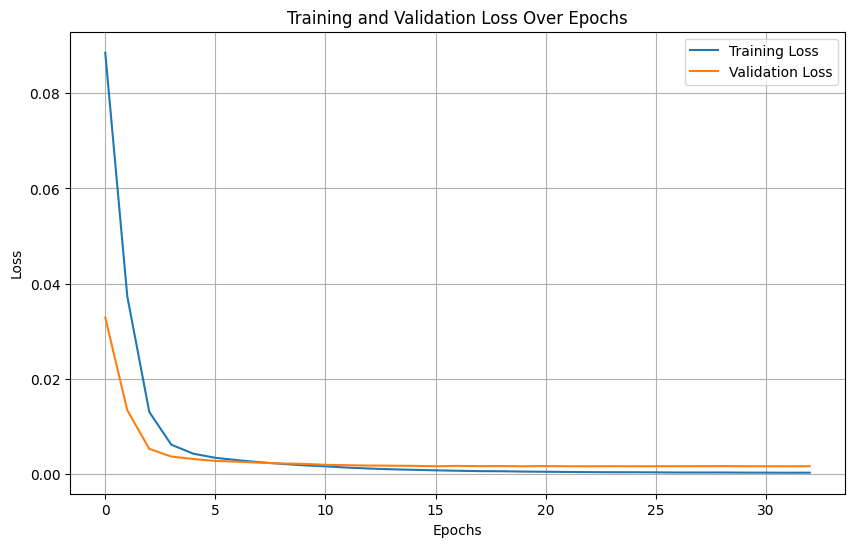

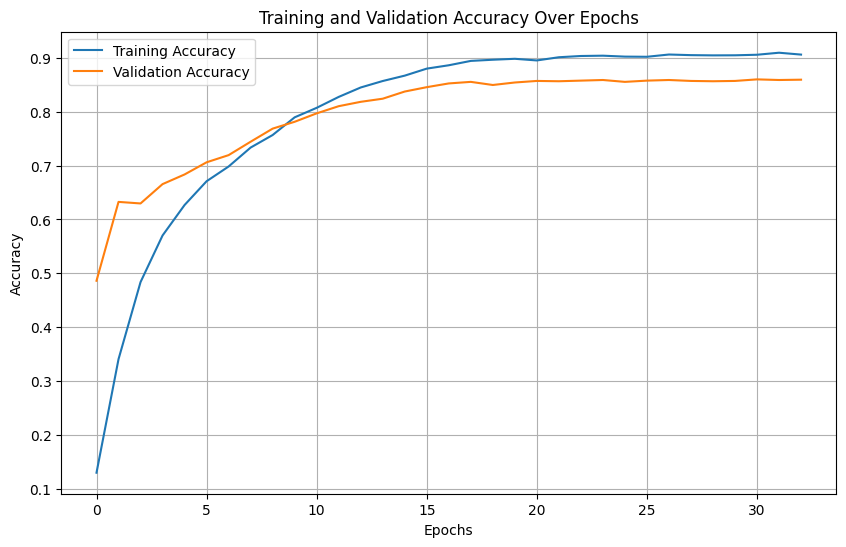

In [12]:
# Loss and Accuracy over Epochs
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


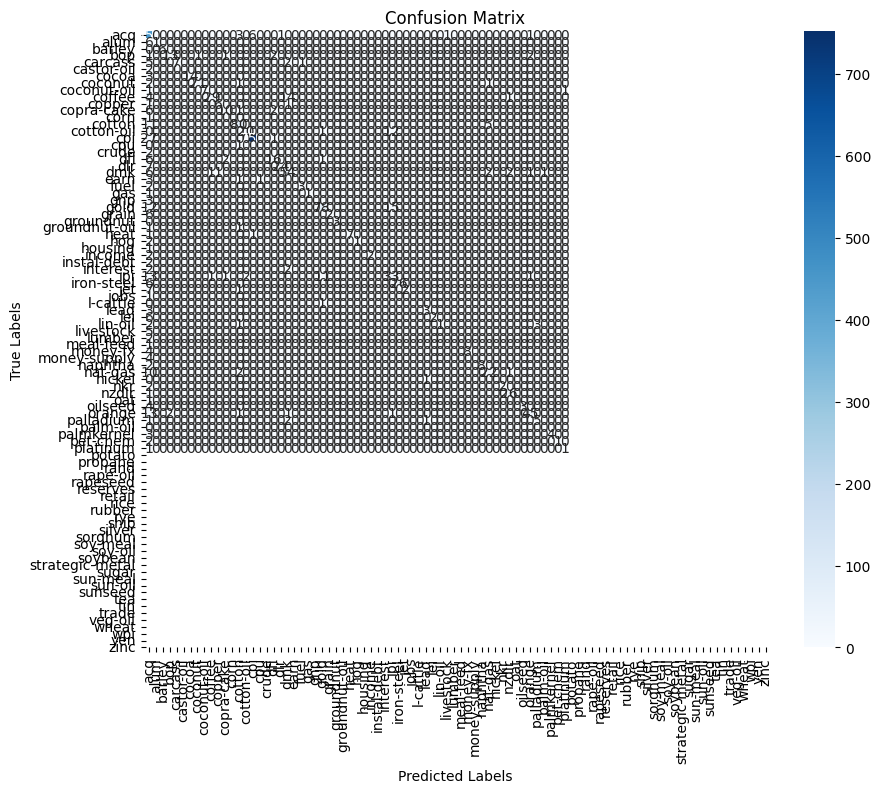

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for one sample class (multi-label case needs further adaptation)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_binary.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


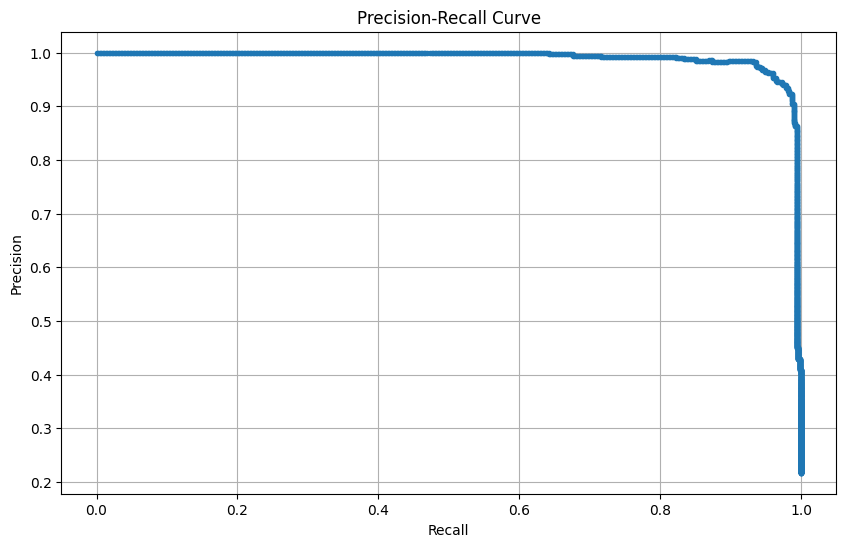

In [14]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

# Compute precision-recall for one label (generalize this for all classes as needed)
precision, recall, thresholds = precision_recall_curve(y_test[:, 0], y_pred[:, 0])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


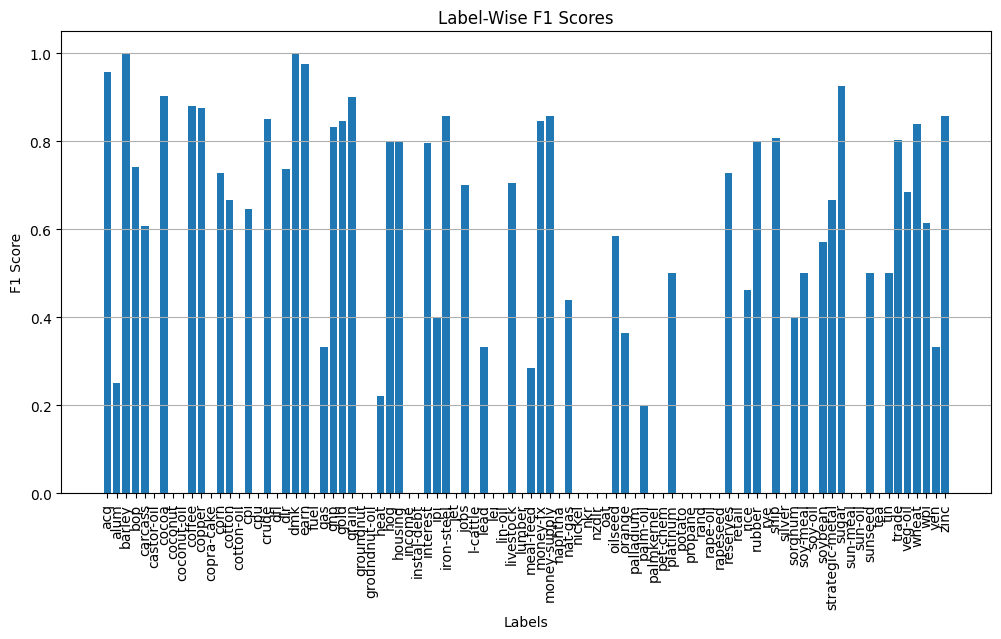

In [15]:
# Label-Wise F1 Scores
from sklearn.metrics import f1_score

# Compute F1 scores for each label
f1_scores = f1_score(y_test, y_pred_binary, average=None)
plt.figure(figsize=(12, 6))
plt.bar(range(len(mlb.classes_)), f1_scores, tick_label=mlb.classes_)
plt.title('Label-Wise F1 Scores')
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

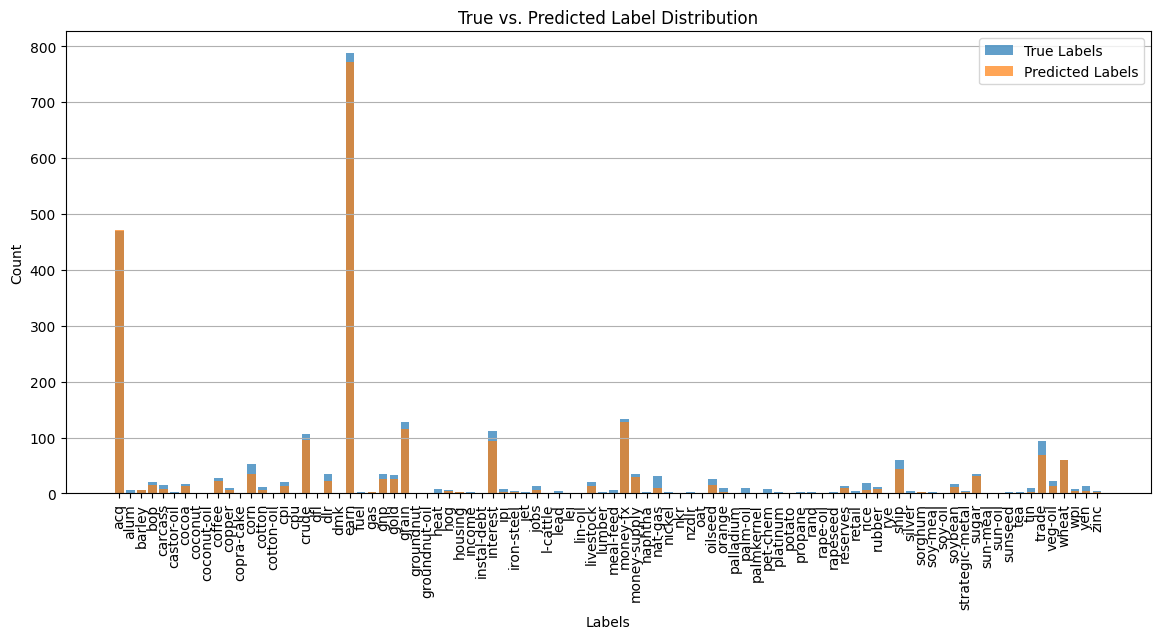

In [16]:
# Predicted vs. True Label Distribution
# Plot true label distribution
true_label_counts = y_test.sum(axis=0)
pred_label_counts = y_pred_binary.sum(axis=0)

plt.figure(figsize=(14, 6))
x_labels = range(len(mlb.classes_))

plt.bar(x_labels, true_label_counts, alpha=0.7, label='True Labels')
plt.bar(x_labels, pred_label_counts, alpha=0.7, label='Predicted Labels')
plt.title('True vs. Predicted Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(x_labels, mlb.classes_, rotation=90)
plt.legend()
plt.grid(axis='y')
plt.show()


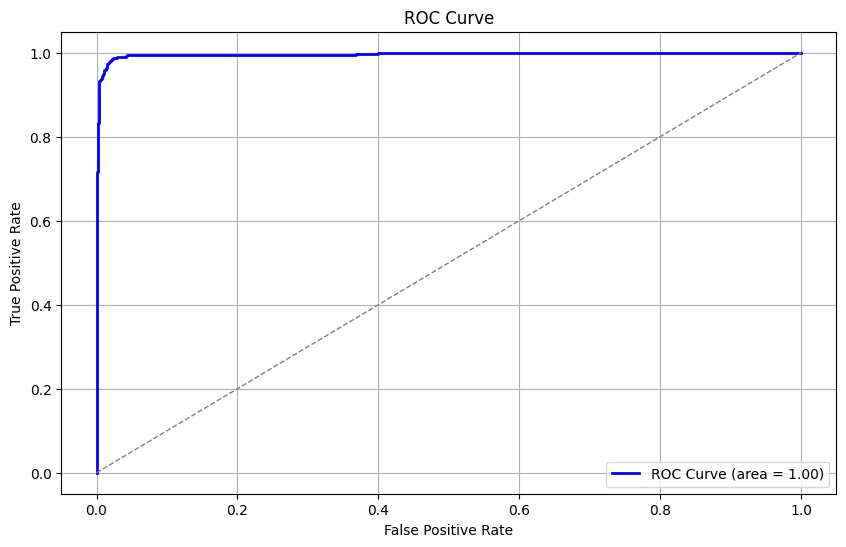

In [17]:
# ROC Curve (Optional)
from sklearn.metrics import roc_curve, auc

# Compute ROC curve for the first label
fpr, tpr, _ = roc_curve(y_test[:, 0], y_pred[:, 0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()
